In [5]:
import os
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix
from sklearn import metrics, preprocessing
import timm
import albumentations as A
import wandb

In [3]:
print(torch.__version__)

2.1.0.dev20230704


##### Parameters

In [4]:
CFG = {
    'seed': 42,
    'model': 'inception_resnet_v2',
    'img_size': 256,
    'epochs': 200,
    'train_bs':128,
    'valid_bs':64,
    'lr': 1e-4,
    'num_workers': 10,
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 6,
    'model_path': './models'
}

#### Train dataset
##### Disaster coco: 894 // flickr: 184 // open_image: 616 // aug 6620 // generated 1782
##### Non-disaster coco: 30000 // open_image: 30000
---
###### disaster, non-disaster 아래 모든 이미지를 들고 옵니다.

In [9]:
folder_path = './data/generated_images/train'
files = os.listdir(folder_path)
print(len(files))
#files

7001


In [5]:
label_list = ["natural","generated"]

generated_img_dir = './data/generated_images'
natural_img_dir = './data/natural_images'
data_form = ['train', 'vaild','test']

train_img_paths = []
train_img_labels = []




def image_label_list():
    for label in label_list: ## 각 레이블 돌기
        print(f'label: {label}',end=' ')
        img_paths = [] 
        img_labels = []
     
    dir_path =  s.path.join(dir_path, label)  ## 레이블 폴더 경로

    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
    
    print(len(img_paths))

    train_img_paths.extend(img_paths)
    train_img_labels.extend(img_labels)

print('Train_Images: ',len(train_img_paths))
print("Train_Images_labels:", len(train_img_labels))

label: disaster 10057
label: non_disaster 60000
Train_Images:  70057
Train_Images_labels: 70057


In [6]:
## Pandas Dataframe
trn_df = pd.DataFrame(train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df ['image_id']. apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = train_img_labels
train = trn_df
train

,image_id,dir,label
0,In this image there are so many trees on the m...,../Data/disaster/train/disaster/generated1/ope...,disaster
1,In the center of the image there is a tree. At...,../Data/disaster/train/disaster/generated1/ope...,disaster
2,In this picture I see a van in front which is ...,../Data/disaster/train/disaster/generated1/ope...,disaster
3,In this picture we can see a person standing h...,../Data/disaster/train/disaster/generated1/ope...,disaster
4,In this image there is a person carrying a bag...,../Data/disaster/train/disaster/generated1/ope...,disaster
...,...,...,...
70052,0599144da6c18a15.jpg,../Data/disaster/train/non_disaster/open_images,non_disaster
70053,0eeff61eee2ce4bf.jpg,../Data/disaster/train/non_disaster/open_images,non_disaster
70054,0578a94b2f1b28de.jpg,../Data/disaster/train/non_disaster/open_images,non_disaster
70055,075d26862f3320db.jpg,../Data/disaster/train/non_disaster/open_images,non_disaster


In [7]:
## Label encoding (0: non-disaster ~ 1: disaster)
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)
train

,image_id,dir,label
0,In this image there are so many trees on the m...,../Data/disaster/train/disaster/generated1/ope...,0
1,In the center of the image there is a tree. At...,../Data/disaster/train/disaster/generated1/ope...,0
2,In this picture I see a van in front which is ...,../Data/disaster/train/disaster/generated1/ope...,0
3,In this picture we can see a person standing h...,../Data/disaster/train/disaster/generated1/ope...,0
4,In this image there is a person carrying a bag...,../Data/disaster/train/disaster/generated1/ope...,0
...,...,...,...
70052,0599144da6c18a15.jpg,../Data/disaster/train/non_disaster/open_images,1
70053,0eeff61eee2ce4bf.jpg,../Data/disaster/train/non_disaster/open_images,1
70054,0578a94b2f1b28de.jpg,../Data/disaster/train/non_disaster/open_images,1
70055,075d26862f3320db.jpg,../Data/disaster/train/non_disaster/open_images,1


#### Wandb (Trainning log tracking) init, project name define 

In [8]:
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'disaster_'+ 'icp_res'
user = 'hojunking'
run_name = project_name + '_' + run_id

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        #im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

##### All images have been augmented physically, only transform the images to be resized by 256 by 256

In [11]:
transform_train = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.pytorch.transforms.ToTensorV2()
        ])

#### Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, transform=None, output_label=True):
        super(CustomDataset,self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.data_root = data_root
        self.output_label = output_label
         
        if output_label == True:
            self.labels = self.df['label'].values
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # GET LABELS
        if self.output_label:
            target = self.labels[index]
            transformed =self.transform(image=img)
            img = transformed['image']
            return img, target
        else:
            transformed =self.transform(image=img)
            img = transformed['image']
            return img

#### Model Define

In [13]:
class baseModel(nn.Module):
    def __init__(self, model_arch, n_class=2, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
        # n_features = self.model.classifier.in_features
        # self.model.classifier = nn.Linear(n_features, n_class)
    
    ### Layer Freezing
    def freezing(self, freeze=False, trainable_layer = 2):
        
        if freeze:
            num_layers = len(list(model.parameters()))
            for i, param in enumerate(model.parameters()):
                if i < num_layers - trainable_layer*2:
                    param.requires_grad = False    
            
    def forward(self, x):
        x = self.model(x)
        return x

##### Define Dataloader

In [14]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
        
    train_ds = CustomDataset(train_, train_data_root, transform=transform_train, output_label=True)
    valid_ds = CustomDataset(valid_, valid_data_root, transform=transform_test,  output_label=True)

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,
        sampler=False, 
        num_workers=CFG['num_workers'],
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

#### Train

In [15]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    t = time.time()
    
    # SET MODEL TRAINING MODE
    model.train()
    
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # TEACHER MODEL PREDICTION
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

##### Valid

In [16]:
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    t = time.time()
    
    # SET MODEL VALID MODE
    model.eval()
    
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        # TEACHER MODEL PREDICTION
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        # TQDM
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

##### Define EarlyStopping

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # EARLY STOPPING DEFINITION
    early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

    # DATALOADER DEFINITION
    train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

    # MODEL & DEVICE DEFINITION 
    device = torch.device(CFG['device'])
    model =baseModel(CFG['model'], train.label.nunique(), pretrained=True)
    
    # MODEL FREEZING
    #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
    if CFG['freezing'] ==True:
        for name, param in model.named_parameters():
            if param.requires_grad == True:
                print(f"{name}: {param.requires_grad}")

    model.to(device)
    # MODEL DATA PARALLEL
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    scaler = torch.cuda.amp.GradScaler()   
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

    # CRITERION (LOSS FUNCTION)
    loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)

    wandb.watch(model, loss_tr, log='all')
    train_acc_list = []
    train_matrix_list = []
    train_f1_list = []
    valid_acc_list = []
    valid_matrix_list = []
    valid_f1_list = []
    

    start = time.time()
    for epoch in range(CFG['epochs']):
        print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

        # TRAINIG
        train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                    optimizer, train_loader, device, scheduler=scheduler)
        wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

        # VALIDATION
        with torch.no_grad():
            valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                    val_loader, device, scheduler=None)
            wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
        print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
        
        # SAVE ALL RESULTS
        train_acc_list.append(train_acc)
        train_matrix_list.append(train_matrix)
        train_f1_list.append(train_f1)

        valid_acc_list.append(valid_acc)
        valid_matrix_list.append(valid_matrix)
        valid_f1_list.append(valid_f1)

        # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
        if valid_f1 > best_f1:
            best_f1 = valid_f1
            best_epoch = epoch
            # SAVE WITH DATAPARARELLEL WRAPPER
            #torch.save(model.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))
            # SAVE WITHOUT DATAPARARELLEL WRAPPER
            torch.save(model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))

        # EARLY STOPPING
        stop = early_stopping(valid_f1)
        if stop:
            print("stop called")   
            break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])


#### Test dataset non-disaster 20000 // disaster 400

In [19]:
test_path = "../Data/disaster/test/"
label_list = ["disaster","non_disaster"]

test_img_paths = []
test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []
    dir_path = test_path + label ## 레이블 폴더 경로

    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
    
    print(len(img_paths))

    test_img_paths.extend(img_paths)
    test_img_labels.extend(img_labels)

print('Test_Images: ',len(test_img_paths))
print("Test_Images_labels:", len(test_img_labels))

label: disaster 400
label: non_disaster 20000
Test_Images:  20400
Test_Images_labels: 20400


In [20]:
## Pandas Dataframe
tst_df = pd.DataFrame(test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = test_img_labels
test = tst_df
test

,image_id,dir,label
0,a8271e8c2fa02700.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster
1,bb92b3c52eb018c8.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster
2,cbf5687e145dc19f.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster
3,54703d04c4271a5a.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster
4,a07b85e2b03909c1.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster
...,...,...,...
20395,0b61646f2795ca9b.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster
20396,0b16c09057d87676.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster
20397,07ddddad35140b20.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster
20398,0143bd9e146f6ded.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster


In [21]:
## Encoding test data labels
test['label'] = le.transform(test['label'].values)
test

,image_id,dir,label
0,a8271e8c2fa02700.jpg,../Data/disaster/test/disaster/origin_images/o...,0
1,bb92b3c52eb018c8.jpg,../Data/disaster/test/disaster/origin_images/o...,0
2,cbf5687e145dc19f.jpg,../Data/disaster/test/disaster/origin_images/o...,0
3,54703d04c4271a5a.jpg,../Data/disaster/test/disaster/origin_images/o...,0
4,a07b85e2b03909c1.jpg,../Data/disaster/test/disaster/origin_images/o...,0
...,...,...,...
20395,0b61646f2795ca9b.jpg,../Data/disaster/test/non_disaster/open_images,1
20396,0b16c09057d87676.jpg,../Data/disaster/test/non_disaster/open_images,1
20397,07ddddad35140b20.jpg,../Data/disaster/test/non_disaster/open_images,1
20398,0143bd9e146f6ded.jpg,../Data/disaster/test/non_disaster/open_images,1


In [22]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

##### Test

In [23]:
# RUN INFERENCE
model = baseModel(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/disaster_icp_res_202307080058/' + CFG['model'] + '.pth'
test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

#INFERENCE VIA MULTI-GPU
if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
test

100%|█████████████████████████████████████████| 160/160 [00:56<00:00,  2.85it/s]


,image_id,dir,label,pred
0,a8271e8c2fa02700.jpg,../Data/disaster/test/disaster/origin_images/o...,0,1
1,bb92b3c52eb018c8.jpg,../Data/disaster/test/disaster/origin_images/o...,0,0
2,cbf5687e145dc19f.jpg,../Data/disaster/test/disaster/origin_images/o...,0,0
3,54703d04c4271a5a.jpg,../Data/disaster/test/disaster/origin_images/o...,0,1
4,a07b85e2b03909c1.jpg,../Data/disaster/test/disaster/origin_images/o...,0,0
...,...,...,...,...
20395,0b61646f2795ca9b.jpg,../Data/disaster/test/non_disaster/open_images,1,1
20396,0b16c09057d87676.jpg,../Data/disaster/test/non_disaster/open_images,1,1
20397,07ddddad35140b20.jpg,../Data/disaster/test/non_disaster/open_images,1,1
20398,0143bd9e146f6ded.jpg,../Data/disaster/test/non_disaster/open_images,1,1


In [24]:
## Decode labels & Predictions
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,a8271e8c2fa02700.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster,non_disaster
1,bb92b3c52eb018c8.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster,disaster
2,cbf5687e145dc19f.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster,disaster
3,54703d04c4271a5a.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster,non_disaster
4,a07b85e2b03909c1.jpg,../Data/disaster/test/disaster/origin_images/o...,disaster,disaster
...,...,...,...,...
20395,0b61646f2795ca9b.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster,non_disaster
20396,0b16c09057d87676.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster,non_disaster
20397,07ddddad35140b20.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster,non_disaster
20398,0143bd9e146f6ded.jpg,../Data/disaster/test/non_disaster/open_images,non_disaster,non_disaster


accuracy: 0.9915
f1_score: 0.8912


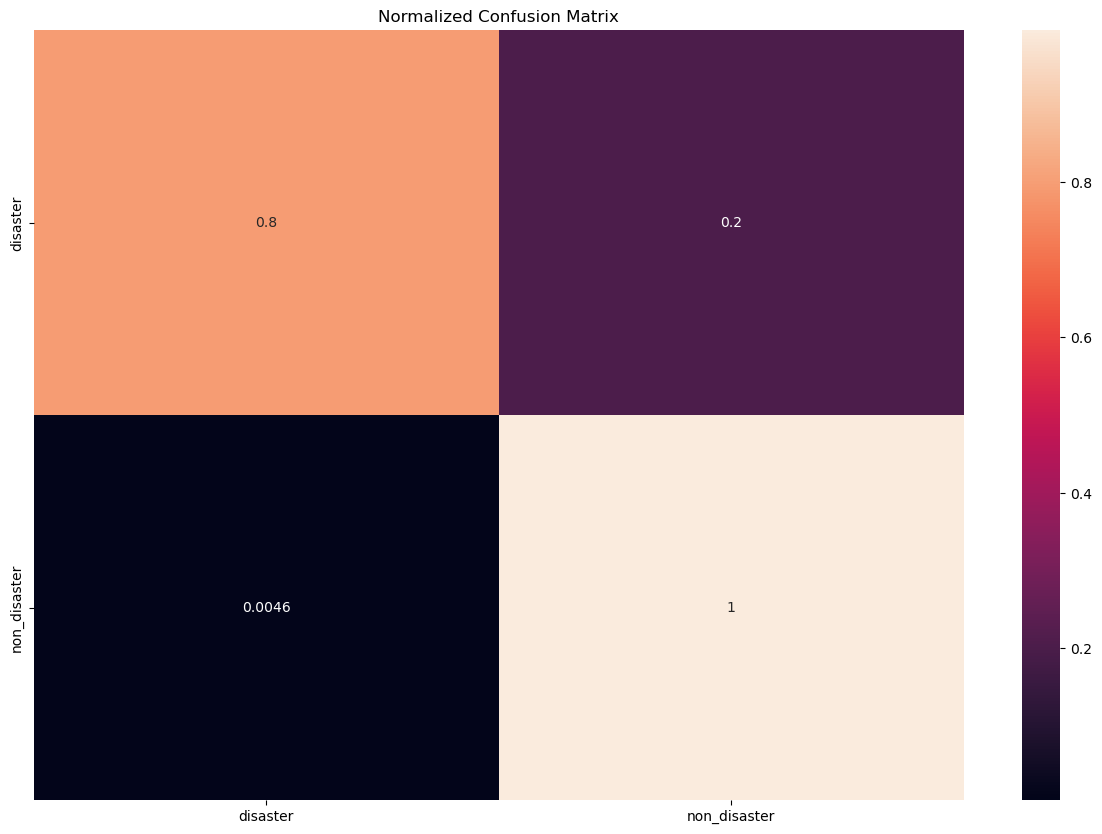

In [26]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')